In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = "/content/drive/MyDrive/MNIST_dataset"

In [3]:
import numpy as np
import struct

base_path = "/content/drive/MyDrive/MNIST_dataset"

def load_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num, rows * cols)
        return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# Load training data
X_train = load_images(base_path + "/train-images.idx3-ubyte")
y_train = load_labels(base_path + "/train-labels.idx1-ubyte")

# Load test data
X_test = load_images(base_path + "/t10k-images.idx3-ubyte")
y_test = load_labels(base_path + "/t10k-labels.idx1-ubyte")

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (60000, 784)
Test: (10000, 784)


In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
def one_hot(y, num_classes=10):
    onehot = np.zeros((y.size, num_classes))
    onehot[np.arange(y.size), y] = 1
    return onehot

y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)

In [9]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [10]:
def train_mlp(hidden_size=128, learning_rate=0.01, batch_size=64,
              activation_name="relu", epochs=10):

    input_size = 784
    output_size = 10

    np.random.seed(42)

    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))

    losses = []
    accuracies = []

    for epoch in range(epochs):

        indices = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]

        for i in range(0, X_train.shape[0], batch_size):

            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]

            Z1 = X_batch.dot(W1) + b1

            if activation_name == "relu":
                A1 = relu(Z1)
            else:
                A1 = tanh(Z1)

            Z2 = A1.dot(W2) + b2
            y_hat = softmax(Z2)

            # Cross entropy
            loss = -np.mean(np.sum(y_batch * np.log(y_hat + 1e-8), axis=1))

            # Backprop
            dZ2 = y_hat - y_batch
            dW2 = A1.T.dot(dZ2) / batch_size
            db2 = np.sum(dZ2, axis=0, keepdims=True) / batch_size

            dA1 = dZ2.dot(W2.T)

            if activation_name == "relu":
                dZ1 = dA1 * relu_derivative(Z1)
            else:
                dZ1 = dA1 * tanh_derivative(Z1)

            dW1 = X_batch.T.dot(dZ1) / batch_size
            db1 = np.sum(dZ1, axis=0, keepdims=True) / batch_size

            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1

        # Test Accuracy
        Z1_test = X_test.dot(W1) + b1

        if activation_name == "relu":
            A1_test = relu(Z1_test)
        else:
            A1_test = tanh(Z1_test)

        Z2_test = A1_test.dot(W2) + b2
        y_hat_test = softmax(Z2_test)

        predictions = np.argmax(y_hat_test, axis=1)
        accuracy = np.mean(predictions == y_test)

        losses.append(loss)
        accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Accuracy: {accuracy:.4f}")

    return losses, accuracies

In [11]:
loss_relu, acc_relu = train_mlp(
    hidden_size=128,
    learning_rate=0.01,
    batch_size=64,
    activation_name="relu",
    epochs=10
)

Epoch 1/10 | Loss: 1.0798 | Accuracy: 0.7756
Epoch 2/10 | Loss: 0.5625 | Accuracy: 0.8695
Epoch 3/10 | Loss: 0.2993 | Accuracy: 0.8914
Epoch 4/10 | Loss: 0.3300 | Accuracy: 0.9011
Epoch 5/10 | Loss: 0.2893 | Accuracy: 0.9066
Epoch 6/10 | Loss: 0.3603 | Accuracy: 0.9111
Epoch 7/10 | Loss: 0.5642 | Accuracy: 0.9161
Epoch 8/10 | Loss: 0.1098 | Accuracy: 0.9199
Epoch 9/10 | Loss: 0.3998 | Accuracy: 0.9221
Epoch 10/10 | Loss: 0.6219 | Accuracy: 0.9251


In [12]:
loss_tanh, acc_tanh = train_mlp(
    hidden_size=128,
    learning_rate=0.01,
    batch_size=64,
    activation_name="tanh",
    epochs=10
)

Epoch 1/10 | Loss: 1.0038 | Accuracy: 0.7906
Epoch 2/10 | Loss: 0.5865 | Accuracy: 0.8706
Epoch 3/10 | Loss: 0.3246 | Accuracy: 0.8920
Epoch 4/10 | Loss: 0.3311 | Accuracy: 0.9014
Epoch 5/10 | Loss: 0.2839 | Accuracy: 0.9071
Epoch 6/10 | Loss: 0.3802 | Accuracy: 0.9105
Epoch 7/10 | Loss: 0.5650 | Accuracy: 0.9147
Epoch 8/10 | Loss: 0.1026 | Accuracy: 0.9163
Epoch 9/10 | Loss: 0.3998 | Accuracy: 0.9183
Epoch 10/10 | Loss: 0.5984 | Accuracy: 0.9214


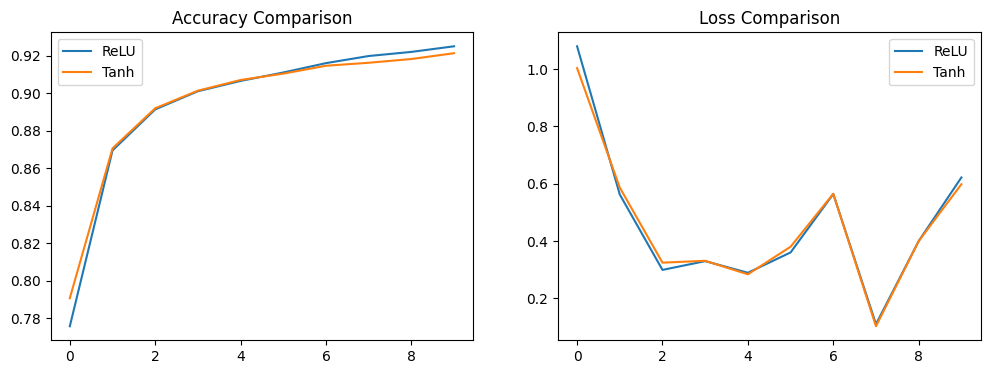

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(acc_relu, label="ReLU")
plt.plot(acc_tanh, label="Tanh")
plt.title("Accuracy Comparison")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss_relu, label="ReLU")
plt.plot(loss_tanh, label="Tanh")
plt.title("Loss Comparison")
plt.legend()

plt.show()

In [15]:
loss_small, acc_small = train_mlp(
    hidden_size=64,
    learning_rate=0.01,
    batch_size=64,
    activation_name="relu",
    epochs=10
)

Epoch 1/10 | Loss: 1.3022 | Accuracy: 0.7511
Epoch 2/10 | Loss: 0.4516 | Accuracy: 0.8605
Epoch 3/10 | Loss: 0.5406 | Accuracy: 0.8865
Epoch 4/10 | Loss: 0.2931 | Accuracy: 0.8973
Epoch 5/10 | Loss: 0.4648 | Accuracy: 0.9038
Epoch 6/10 | Loss: 0.2343 | Accuracy: 0.9103
Epoch 7/10 | Loss: 0.4459 | Accuracy: 0.9134
Epoch 8/10 | Loss: 0.1570 | Accuracy: 0.9169
Epoch 9/10 | Loss: 0.2244 | Accuracy: 0.9194
Epoch 10/10 | Loss: 0.3669 | Accuracy: 0.9224


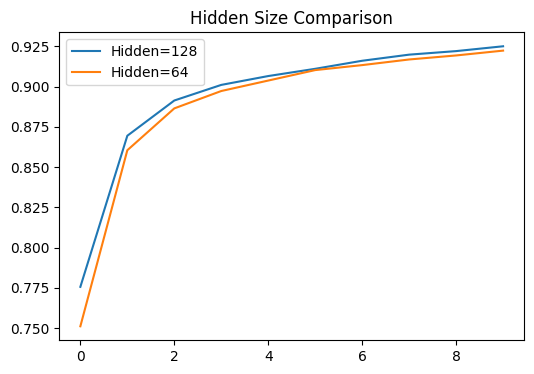

In [16]:
plt.figure(figsize=(6,4))
plt.plot(acc_relu, label="Hidden=128")
plt.plot(acc_small, label="Hidden=64")
plt.title("Hidden Size Comparison")
plt.legend()
plt.show()

Initialize Undercomplete Autoencoder

In [17]:
encoding_dim = 64
learning_rate = 0.01
epochs = 20

np.random.seed(42)

W1 = np.random.randn(784, encoding_dim) * 0.01
b1 = np.zeros((1, encoding_dim))
W2 = np.random.randn(encoding_dim, 784) * 0.01
b2 = np.zeros((1, 784))

In [18]:
ae_losses = []

for epoch in range(epochs):

    Z1 = X_train.dot(W1) + b1
    A1 = relu(Z1)
    Z2 = A1.dot(W2) + b2
    X_hat = 1 / (1 + np.exp(-Z2))  # sigmoid output

    loss = np.mean((X_train - X_hat) ** 2)
    ae_losses.append(loss)

    # Backprop
    dZ2 = (X_hat - X_train) * X_hat * (1 - X_hat)
    dW2 = A1.T.dot(dZ2) / X_train.shape[0]
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X_train.shape[0]

    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X_train.T.dot(dZ1) / X_train.shape[0]
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X_train.shape[0]

    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.6f}")

Epoch 1/20 | Loss: 0.231333
Epoch 2/20 | Loss: 0.231086
Epoch 3/20 | Loss: 0.230836
Epoch 4/20 | Loss: 0.230580
Epoch 5/20 | Loss: 0.230313
Epoch 6/20 | Loss: 0.230029
Epoch 7/20 | Loss: 0.229721
Epoch 8/20 | Loss: 0.229378
Epoch 9/20 | Loss: 0.228989
Epoch 10/20 | Loss: 0.228535
Epoch 11/20 | Loss: 0.227993
Epoch 12/20 | Loss: 0.227332
Epoch 13/20 | Loss: 0.226509
Epoch 14/20 | Loss: 0.225471
Epoch 15/20 | Loss: 0.224145
Epoch 16/20 | Loss: 0.222435
Epoch 17/20 | Loss: 0.220221
Epoch 18/20 | Loss: 0.217352
Epoch 19/20 | Loss: 0.213646
Epoch 20/20 | Loss: 0.208895


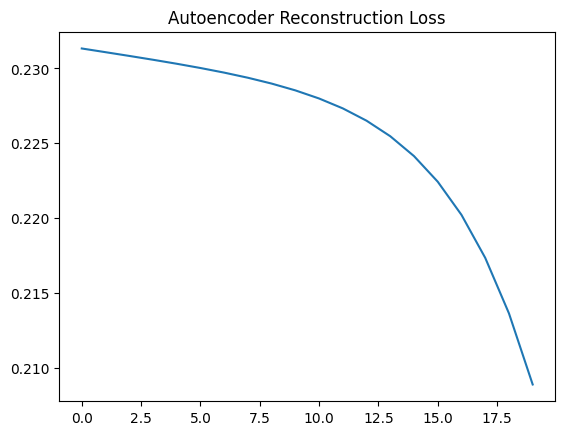

In [19]:
plt.plot(ae_losses)
plt.title("Autoencoder Reconstruction Loss")
plt.show()

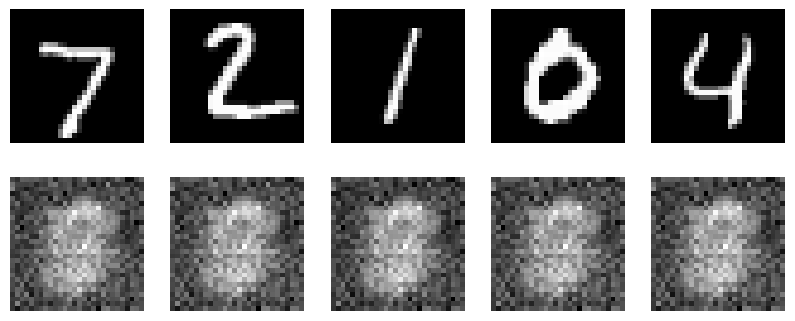

In [20]:
n = 5
Z1 = X_test[:n].dot(W1) + b1
A1 = relu(Z1)
Z2 = A1.dot(W2) + b2
X_reconstructed = 1 / (1 + np.exp(-Z2))

plt.figure(figsize=(10,4))

for i in range(n):
    plt.subplot(2,n,i+1)
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    plt.axis('off')

    plt.subplot(2,n,i+1+n)
    plt.imshow(X_reconstructed[i].reshape(28,28), cmap='gray')
    plt.axis('off')

plt.show()

In [21]:
Z1_all = X_test.dot(W1) + b1
A1_all = relu(Z1_all)
Z2_all = A1_all.dot(W2) + b2
X_hat_all = 1 / (1 + np.exp(-Z2_all))

errors = np.mean((X_test - X_hat_all)**2, axis=1)

threshold = np.mean(errors) + 2*np.std(errors)

print("Outlier Threshold:", threshold)

outliers = np.where(errors > threshold)[0]
print("Number of detected outliers:", len(outliers))

Outlier Threshold: 0.21891776969477036
Number of detected outliers: 398


RBM (Proper + Filters Visualization)


In [22]:
visible_units = 784
hidden_units = 64
learning_rate = 0.01
epochs = 10

np.random.seed(42)

W = np.random.randn(visible_units, hidden_units) * 0.01
b = np.zeros((1, hidden_units))
c = np.zeros((1, visible_units))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [23]:
rbm_losses = []

for epoch in range(epochs):

    v0 = X_train[:2000]  # small subset for speed

    # Positive phase
    h_prob = sigmoid(v0.dot(W) + b)
    h_sample = (h_prob > np.random.rand(*h_prob.shape)).astype(float)

    # Negative phase
    v_prob = sigmoid(h_sample.dot(W.T) + c)
    h_prob_new = sigmoid(v_prob.dot(W) + b)

    # Update weights
    W += learning_rate * (v0.T.dot(h_prob) - v_prob.T.dot(h_prob_new)) / v0.shape[0]

    loss = np.mean((v0 - v_prob)**2)
    rbm_losses.append(loss)

    print(f"Epoch {epoch+1}/{epochs} | Reconstruction Error: {loss:.6f}")

Epoch 1/10 | Reconstruction Error: 0.231496
Epoch 2/10 | Reconstruction Error: 0.218979
Epoch 3/10 | Reconstruction Error: 0.211651
Epoch 4/10 | Reconstruction Error: 0.206120
Epoch 5/10 | Reconstruction Error: 0.201248
Epoch 6/10 | Reconstruction Error: 0.196649
Epoch 7/10 | Reconstruction Error: 0.192355
Epoch 8/10 | Reconstruction Error: 0.187818
Epoch 9/10 | Reconstruction Error: 0.183458
Epoch 10/10 | Reconstruction Error: 0.179238


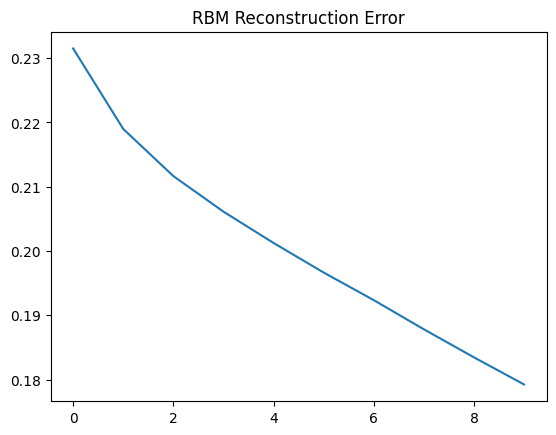

In [24]:
plt.plot(rbm_losses)
plt.title("RBM Reconstruction Error")
plt.show()

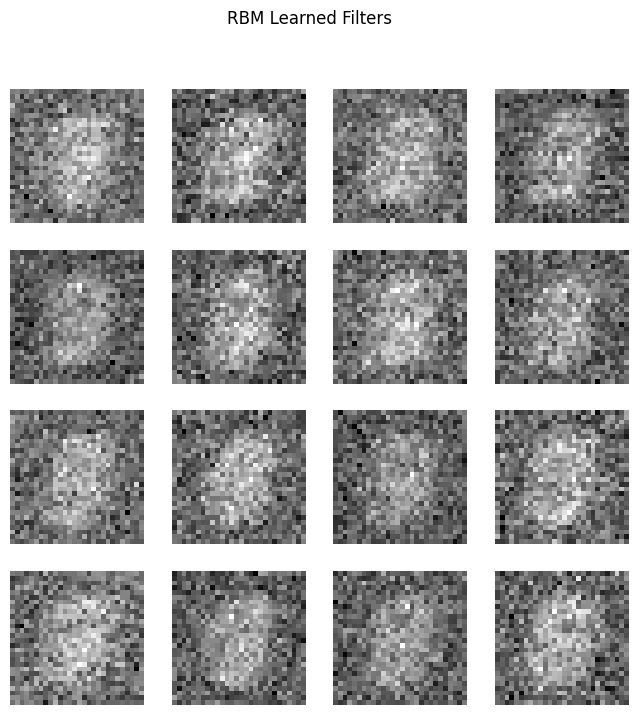

In [26]:
plt.figure(figsize=(8,8))

for i in range(16):  # show 16 filters
    plt.subplot(4,4,i+1)
    plt.imshow(W[:,i].reshape(28,28), cmap='gray')
    plt.axis('off')

plt.suptitle("RBM Learned Filters")
plt.show()